## **Detection of Improperly Worn Face Masks**
Following is the implementation of the pre-trained model which I trained on my self created dataset.
Here, the saved model is loaded and checked for results

In [1]:
# load and evaluate the saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
# load model 
model = load_model('/content/drive/My Drive/PNG Images - mask detection/imgs/fourth.h5')

In [2]:
#load the required libraries
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time

- check if the image has a face and make a bounding box around it using OpenCV

In [3]:
def detect_and_predict_mask(frame, faceNet, maskNet):
        # get dimensions of the frame and then make a blob 
        (h, w) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
            (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        faceNet.setInput(blob)
        detections = faceNet.forward()

        # initialize our list of faces, their corresponding locations,
        # and the list of predictions from our face mask network
        faces = []
        locs = []
        preds = []

        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with
            # the detection
            confidence = detections[0, 0, i, 2]

            # filter out weak detections by ensuring the confidence is
            # greater than the minimum confidence
            if confidence > 0.5:
                # compute the (x, y)-coordinates of the bounding box for
                # the object
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # ensure the bounding boxes fall within the dimensions of
                # the frame
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # extract the face ROI, convert it from BGR to RGB channel
                # ordering, resize it to 224x224, and preprocess it
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)
                face = np.expand_dims(face, axis=0)

                # add the face and bounding boxes to their respective
                # lists
                faces.append(face)
                locs.append((startX, startY, endX, endY))

        # only make a predictions if at least one face was detected
        if len(faces) > 0:
            # for faster inference we'll make batch predictions on *all*
            # faces at the same time rather than one-by-one predictions
            # in the above `for` loop
            preds = maskNet.predict(faces)

        # return a 2-tuple of the face locations and their corresponding
        # locations
        return (locs, preds)

In [6]:
#import other libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

1. Load the first image to check if the mask is proper or improper

In [7]:
image = cv2.imread("/content/drive/My Drive/PNG Images - mask detection/imgs/multi.jpg")
type(image)

numpy.ndarray

In [10]:
orig = image.copy()
(h, w) = image.shape[:2]

Read the network using cv2.dnn

In [ ]:
Net = cv2.dnn.readNet("/content/drive/My Drive/Colab Notebooks/deploy.prototxt","/content/drive/My Drive/Colab Notebooks/res10_300x300_ssd_iter_140000.caffemodel")

In [28]:
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
Net.setInput(blob)
detections = Net.forward()

In [20]:
# loop over the detections
for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, improperMask) = model.predict(face)[0]

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "PROPER" if mask > improperMask else "IMPROPER"
            color = (0, 255, 0) if label == "PROPER" else (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, improperMask) * 100)

            font_scale = 1.5
            font = cv2.FONT_HERSHEY_PLAIN
            # set the rectangle background to white
            rectangle_bgr = (255, 255, 255)
            # make a black image
            img = np.zeros((500, 500))
            # get the width and height of the text box
            (text_width, text_height) = cv2.getTextSize(label, font, fontScale=font_scale, thickness=8)[0]
            # set the text start position
            text_offset_x = 10
            text_offset_y = image.shape[0] - 25
            # make the coords of the box with a small padding of two pixels
            box_coords = ((startX+2, startY - 4), (startX + text_width + 2, startY - text_height - 2 ))
            cv2.rectangle(image, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            cv2.putText(image, label, (startX+2, startY - 4), font, fontScale=font_scale, color=(0, 0, 0), thickness=2)
               

obtain the output image with the classified detection

In [21]:
# show the output image
from google.colab.patches import cv2_imshow

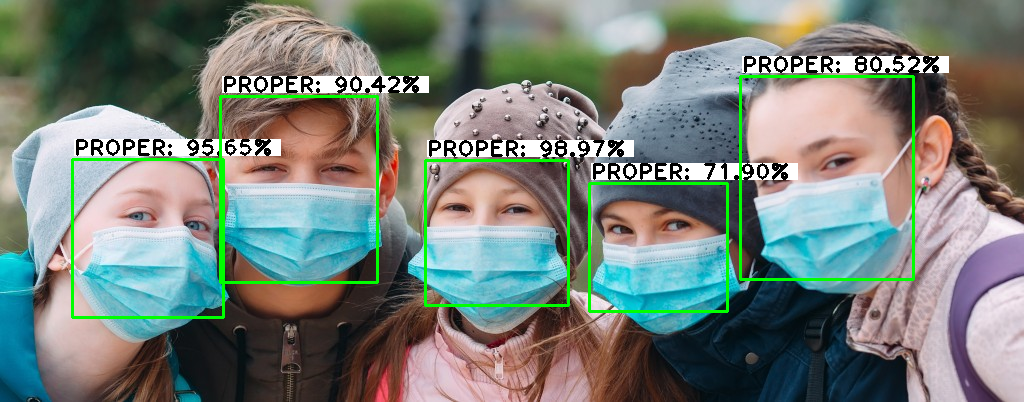

In [22]:
cv2_imshow(image)

The resulted image contains images bounded correctly with a green box and labelled correctly.

2. Upload the second image to check the results of the model

In [23]:
image2 = cv2.imread("/content/drive/My Drive/PNG Images - mask detection/imgs/mask2.jpg")
type(image2)

numpy.ndarray

In [24]:
orig = image2.copy()
(h, w) = image2.shape[:2]

In [25]:
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image2, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
Net.setInput(blob)
detections = Net.forward()

In [26]:
# loop over the detections
for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image2[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, improperMask) = model.predict(face)[0]

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "PROPER" if mask > improperMask else "IMPROPER"
            color = (0, 255, 0) if label == "PROPER" else (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, improperMask) * 100)

            font_scale = 1.5
            font = cv2.FONT_HERSHEY_PLAIN
            # set the rectangle background to white
            rectangle_bgr = (255, 255, 255)
            # make a black image
            img = np.zeros((500, 500))
            # get the width and height of the text box
            (text_width, text_height) = cv2.getTextSize(label, font, fontScale=font_scale, thickness=8)[0]
            # set the text start position
            text_offset_x = 10
            text_offset_y = image2.shape[0] - 25
            # make the coords of the box with a small padding of two pixels
            box_coords = ((startX+2, startY - 4), (startX + text_width + 2, startY - text_height - 2 ))
            cv2.rectangle(image2, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
            cv2.rectangle(image2, (startX, startY), (endX, endY), color, 2)
            cv2.putText(image2, label, (startX+2, startY - 4), font, fontScale=font_scale, color=(0, 0, 0), thickness=2)

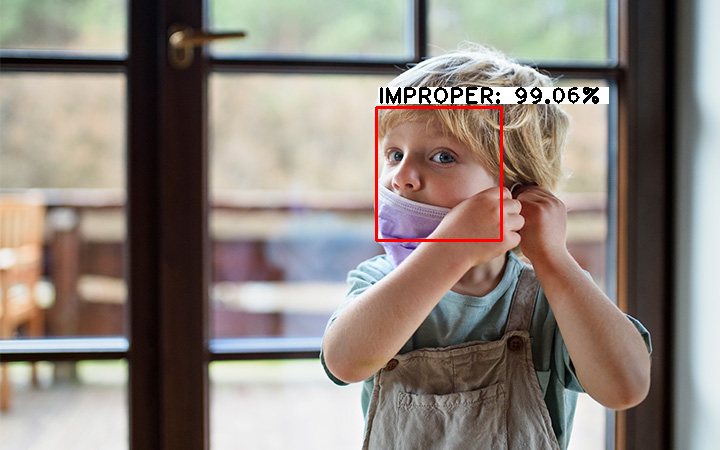

In [27]:
cv2_imshow(image2)

Thus the image is correctly bounded with a red box as coded, and contains the correct Improper label